**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [42]:
# write your code here
from types import SimpleNamespace
from scipy import optimize
import sympy as sm
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sympy import *
from test import LaborEconomicsModelClass

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

We substitute for $C$ and $\tilde{w}$ to get the utility function: $\ln\left(\left(\kappa+\tilde{w}L\right)^{\alpha}G^{1-\alpha}\right)-\nu\frac{L}{2}^{2}$. In the LaborEconomicsModelClass we define the utility function, we then use sympy to take the derivative w.r.t. L. We then solve the FOC. We loop over $G=1$ and $G=2$ and find equivalent expressions for $L^{*}(\tilde{w})$. 

In [43]:
# Create an instance of the model
model = LaborEconomicsModelClass()

# Print the FOC for G = 1.0
model.print_FOC(1.0)

# Print the FOC for G = 2.0
model.print_FOC(2.0)

# Solve the model symbolically for G = 1.0 and G = 2.0
for G in [1.0, 2.0]:
    L_star = model.solve_model_symbolically(G)
    print(f"For G = {G}, L* = {L_star}")


FOC:  1.0**(1 - alpha)*1.0**(alpha - 1)*alpha*wtilde/(L*wtilde + kappa) - L*nu
FOC:  2.0**(1 - alpha)*2.0**(alpha - 1)*alpha*wtilde/(L*wtilde + kappa) - L*nu
For G = 1.0, L* = 0.5*(-kappa*nu - sqrt(nu*(4.0*alpha*wtilde**2 + kappa**2*nu)))/(nu*wtilde)
For G = 2.0, L* = 0.5*(-kappa*nu - sqrt(nu*(4.0*alpha*wtilde**2 + kappa**2*nu)))/(nu*wtilde)


Solving the model analytically for $G=1$ and $G=2$ we find that we cannot verify that $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$. Instead we get that in both cases of $G$ the optimal labour output is $L\left(\tilde{w}^{*}\right)=\frac{-\kappa\nu-\sqrt{\nu\left(4\alpha\tilde{w}^{2}+\kappa^{2}\nu\right)}}{2\nu\tilde{w}}$

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

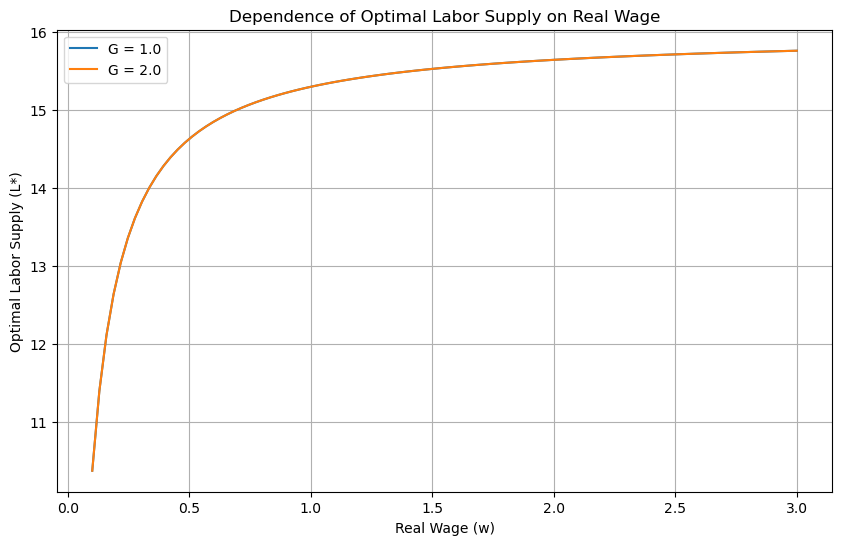

In [44]:


# write your code here
import matplotlib.pyplot as plt
import numpy as np

# define the parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
tau = 0.3
G_values = [1.0,2.0]

# define the function for optimal labor supply choice
def L_star(tilde_w, alpha=alpha, kappa=kappa, nu=nu):
    return (-kappa + np.sqrt(kappa**2 + 4 * alpha / nu * tilde_w**2)) / (2 * tilde_w)

# create a range of wage values
w_values = np.linspace(0.1, 3, 100)

# calculate and plot the optimal labor supply choice for different values of w and G
plt.figure(figsize=(10, 6))
for G in G_values:
    tilde_w_values = (1 - tau) * w_values
    L_star_values = L_star(tilde_w_values)
    plt.plot(w_values, L_star_values, label=f'G = {G}')

plt.xlabel('Real Wage (w)')
plt.ylabel('Optimal Labor Supply (L*)')
plt.title('Dependence of Optimal Labor Supply on Real Wage')
plt.legend()
plt.grid(True)
plt.show()



We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


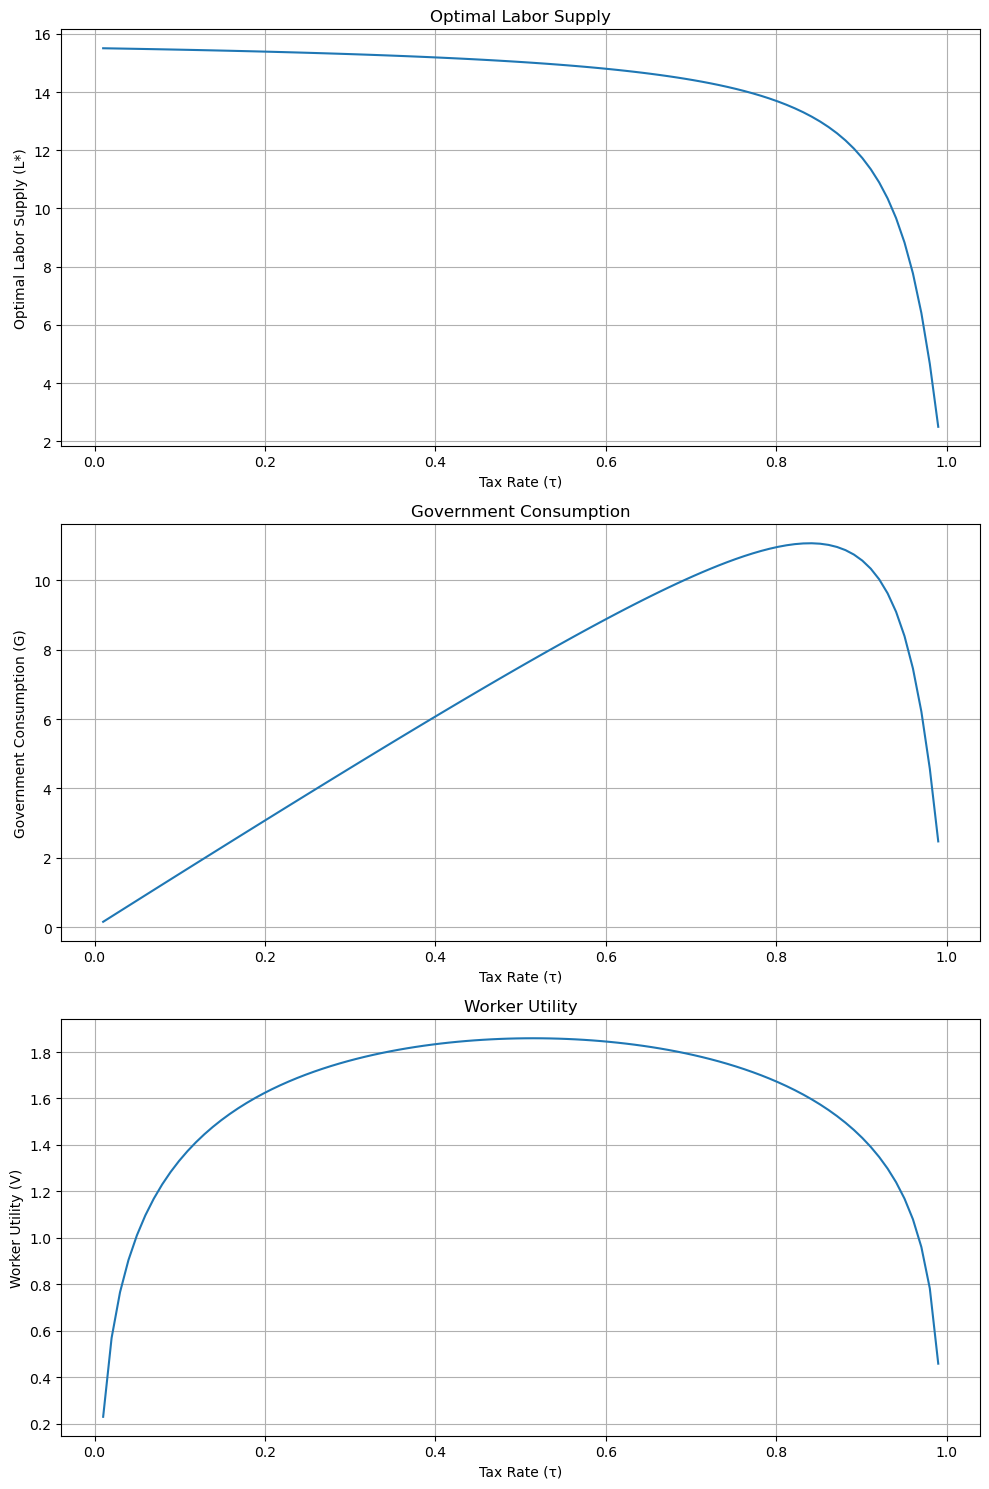

In [45]:
# write your code here

import numpy as np
import matplotlib.pyplot as plt

# define the parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1.0

# define the function for optimal labor supply choice
def L_star(tilde_w, alpha=alpha, kappa=kappa, nu=nu):
    return (-kappa + np.sqrt(kappa**2 + 4 * alpha / nu * tilde_w**2)) / (2 * tilde_w)

# define the function for government consumption
def G(tau, w=w):
    tilde_w = (1 - tau) * w
    L = L_star(tilde_w)
    return tau * w * L

# define the function for worker utility
def V(tau, w=w, alpha=alpha, kappa=kappa, nu=nu):
    tilde_w = (1 - tau) * w
    L = L_star(tilde_w)
    C = kappa + tilde_w * L
    return np.log(C**alpha * G(tau)**(1-alpha)) - nu * L**2 / 2

# create a grid of tax rate values
tau_values = np.linspace(0.01, 0.99, 100)

# calculate the optimal labor supply, government consumption, and worker utility for each tax rate
L_values = [L_star((1 - tau) * w) for tau in tau_values]
G_values = [G(tau) for tau in tau_values]
V_values = [V(tau) for tau in tau_values]

# plot the results
fig, axs = plt.subplots(3, figsize=(10, 15))

axs[0].plot(tau_values, L_values)
axs[0].set_title('Optimal Labor Supply')
axs[0].set_xlabel('Tax Rate (τ)')
axs[0].set_ylabel('Optimal Labor Supply (L*)')
axs[0].grid(True)

axs[1].plot(tau_values, G_values)
axs[1].set_title('Government Consumption')
axs[1].set_xlabel('Tax Rate (τ)')
axs[1].set_ylabel('Government Consumption (G)')
axs[1].grid(True)

axs[2].plot(tau_values, V_values)
axs[2].set_title('Worker Utility')
axs[2].set_xlabel('Tax Rate (τ)')
axs[2].set_ylabel('Worker Utility (V)')
axs[2].grid(True)

plt.tight_layout()
plt.show()


**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

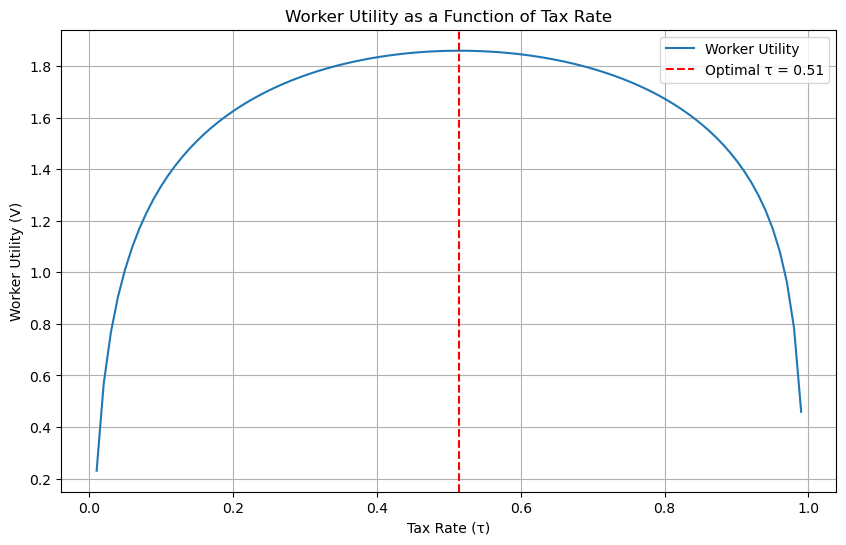

In [46]:
# write your code here

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# define the parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1.0

# define the function for optimal labor supply choice
def L_star(tilde_w, alpha=alpha, kappa=kappa, nu=nu):
    return (-kappa + np.sqrt(kappa**2 + 4 * alpha / nu * tilde_w**2)) / (2 * tilde_w)

# define the function for government consumption
def G(tau, w=w):
    tilde_w = (1 - tau) * w
    L = L_star(tilde_w)
    return tau * w * L

# define the function for worker utility
def V(tau, w=w, alpha=alpha, kappa=kappa, nu=nu):
    tilde_w = (1 - tau) * w
    L = L_star(tilde_w)
    C = kappa + tilde_w * L
    return np.log(C**alpha * G(tau)**(1-alpha)) - nu * L**2 / 2

# the negative of the utility function to minimize
def neg_V(tau):
    return -V(tau)

# find the optimal tax rate that maximizes worker utility
result = minimize(neg_V, [0.5], bounds=[(0.01, 0.99)])
optimal_tau = result.x[0]

# create a grid of tax rate values
tau_values = np.linspace(0.01, 0.99, 100)

# calculate the worker utility for each tax rate
V_values = [V(tau) for tau in tau_values]

# plot the results
plt.figure(figsize=(10, 6))
plt.plot(tau_values, V_values, label='Worker Utility')
plt.axvline(optimal_tau, color='red', linestyle='--', label=f'Optimal τ = {optimal_tau:.2f}')
plt.title('Worker Utility as a Function of Tax Rate')
plt.xlabel('Tax Rate (τ)')
plt.ylabel('Worker Utility (V)')
plt.legend()
plt.grid(True)
plt.show()

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [47]:
from scipy.optimize import fsolve

# define the new utility function
def utility(L, w, tau, G, sigma, rho, epsilon, alpha=alpha, kappa=kappa, nu=nu):
    C = kappa + (1 - tau) * w * L
    term1 = (alpha * C**((sigma - 1) / sigma) + (1 - alpha) * max(G, 0)**((sigma - 1) / sigma))**(sigma / (1 - sigma))
    return (term1**(1 - rho) - 1) / (1 - rho) - nu * L**(1 + epsilon) / (1 + epsilon)

# the negative of the utility function to minimize
def neg_utility(L, w, tau, G, sigma, rho, epsilon):
    return -utility(L, w, tau, G, sigma, rho, epsilon)

# find the optimal labor supply for a given government consumption and tax rate
def L_star(w, tau, G, sigma, rho, epsilon):
    result = minimize(neg_utility, [8], args=(w, tau, G, sigma, rho, epsilon), bounds=[(0, 24)])
    return result.x[0] if result.success else None

# define the function for the government's budget constraint
def budget_constraint(G, w, tau, sigma, rho, epsilon):
    L = L_star(w, tau, G, sigma, rho, epsilon)
    return G - tau * w * L if L is not None else None

# find the level of government consumption that satisfies the government budget constraint
def find_G(w, tau, sigma, rho, epsilon):
    result = fsolve(budget_constraint, [1], args=(w, tau, sigma, rho, epsilon))
    return result[0] if result.size > 0 else None

# Set 1: σ=1.001, ρ=1.001, ε=1.0
G_set1 = find_G(w, optimal_tau, sigma=1.001, rho=1.001, epsilon=1.0)
print(f"For parameter set 1, G = {G_set1:.2f}")

# Set 2: σ=1.5, ρ=1.5, ε=1.0
G_set2 = find_G(w, optimal_tau, sigma=1.5, rho=1.5, epsilon=1.0)
print(f"For parameter set 2, G = {G_set2:.2f}")


For parameter set 1, G = 0.00
For parameter set 2, G = 0.00


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [48]:
from scipy.optimize import minimize

# Set 1: σ = 1.001, ρ = 1.001, ε = 1.0
sigma = 1.001
rho = 1.001
epsilon = 1.0

# Define the constraint function
def constraint(tau, w, sigma, rho, epsilon):
    G = find_G(w, tau, sigma, rho, epsilon)
    L = L_star(w, tau, G, sigma, rho, epsilon)
    return tau * w * L - G

# Define the objective function (negative utility)
def objective(tau, w, sigma, rho, epsilon):
    G = find_G(w, tau, sigma, rho, epsilon)
    L = L_star(w, tau, G, sigma, rho, epsilon)
    return -utility(L, w, tau, G, sigma, rho, epsilon)

# Define initial guess for tau
tau_initial = 0.3

# Set up constraints and bounds
cons = {'type': 'eq', 'fun': constraint, 'args': (w, sigma, rho, epsilon)}
bounds = [(0.01, 0.99)]  # Tau must be in (0, 1)

# Find the optimal tau
optimal_result = minimize(objective, tau_initial, args=(w, sigma, rho, epsilon), constraints=cons, bounds=bounds)
optimal_tau = optimal_result.x[0]

print(f"The socially optimal tax rate for parameter set 1 is τ = {optimal_tau:.2f}")


The socially optimal tax rate for parameter set 1 is τ = 0.30


In [49]:
# Set 2: σ = 1.5, ρ = 1.5, ε = 1.0
sigma = 1.5
rho = 1.5
epsilon = 1.0

# Run the optimization again
optimal_result = minimize(objective, tau_initial, args=(w, sigma, rho, epsilon), constraints=cons, bounds=bounds)
optimal_tau = optimal_result.x[0]

print(f"The socially optimal tax rate for parameter set 2 is τ = {optimal_tau:.2f}")


The socially optimal tax rate for parameter set 2 is τ = 0.30


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

Firstly we insert the baseline values of $\eta, \nu$ and $\kappa$ to get the $\ell_t$ that maximizes profits for the two values of $\kappa$.

In [50]:
# Inserting the baseline parameter values into the given l_t function

kappa_t_values = [1.0, 2.0]
w = 1
eta = 0.5

for kappa_t in kappa_t_values:
    l_t = (kappa_t*(1 - eta)/w)**(1/eta)
    print(f"For \kappa_t = {kappa_t}, l_t = {l_t}")

For \kappa_t = 1.0, l_t = 0.25
For \kappa_t = 2.0, l_t = 1.0


Now we solve it $\ell_t$ ourselves with the baseline values and compare the optimal $\ell_t$ results, to verify that the given equation maximizes profits.

In [51]:
# We solve for l_t ourselves and insert the baseline values to verify it numerically

# Define the symbols
l_t = sm.symbols('l_t')
kappa_t = sm.symbols('kappa_t')
w_value = 1
eta_value = 0.5

# Define the profit function
profit = kappa_t * l_t ** (1 - eta_value) - w_value * l_t

# Take the derivative of the profit function with respect to l_t
profit_derivative = sm.diff(profit, l_t)

# Solve the derivative = 0 for l_t
optimal_l_t = sm.solve(profit_derivative, l_t)

# Print the symbolic solution for optimal l_t
print("Optimal l_t:")
for solution in optimal_l_t:
    print(f"l_t = {solution}")

# Evaluate optimal l_t for given kappa values
kappa_values = [1.0, 2.0]
for kappa in kappa_values:
    print(f"For kappa = {kappa}, optimal l_t = {solution.subs(kappa_t, kappa):.2f}")

Optimal l_t:
l_t = 0.25*kappa_t**2
For kappa = 1.0, optimal l_t = 0.25
For kappa = 2.0, optimal l_t = 1.00


We see above that our results is equal to the results of the given equation for $\ell_t$ and we can therefore verify that this maximizes profits for $\kappa \in \{1.0,2.0\}$

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [52]:
import numpy as np

# Set the parameters
rho = 0.9
iota = 0.01
sigma_epsilon = 0.1
R = (1+0.01)**(1/12)
eta = 0.5
w = 1
K = 10000
T = 120
np.random.seed(123)

def calculate_H():
    total_value = 0
    
# Looping over K diferent shocks
    for k in range(K):
        epsilon = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=T)
# Enabling the array, kappa, to store demand shocks 
        kappa = np.empty(T)
        kappa[0] = np.exp(rho*np.log(1) + epsilon[0])
# Looping over the rest of the time periods
        for t in range(1, T):
            kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon[t])
        l = ((1-eta)*kappa/w)**(1/eta)
# Calculating the ex post value of the salon
        h = np.sum([(kappa[t]*l[t]**(1-eta) - w*l[t] - iota*(l[t] != l[t-1]))*R**(-t) for t in range(T)])
# Adding ex post value of the salon to total value 
        total_value += h
    
    return total_value / K
# Calculating the ex ante expected value 
H = calculate_H()

print(f"The value of the salon H is {H}.")


The value of the salon H is 27.739272877786465.


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

We continue in the same style of code, with the addition of policies:

In [53]:
import numpy as np

np.random.seed(123)
# Set the parameters
rho = 0.9
iota = 0.01
sigma_epsilon = 0.1
R = (1+0.01)**(1/12)
eta = 0.5
w = 1
K = 1000
T = 120
Delta = 0.05

def calculate_H():
    # Initialize the total value of the salon to be zero
    total_value = 0
    
    # Loop over the K different shock series
    for k in range(K):
        # Generate a series of shock values epsilon with normal distribution
        epsilon = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=T)
        
        # Initialize the array to store the demand shocks kappa
        kappa = np.empty(T)
        
        # Calculate the first demand shock kappa[0] using the given AR(1) process
        kappa[0] = np.exp(rho*np.log(1) + epsilon[0])
        
        # Initialize the number of employees in the last period to be zero
        l_last = 0

        # Initialize the list to store the number of employees in each period
        l = []
        
        # Loop over all the time periods
        for t in range(T):
            # If it's not the first period, calculate the demand shock kappa[t] using the AR(1) process
            if t > 0:
                kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon[t])
            
            # Calculate the optimal number of employees l_star for this time period
            l_star = ((1-eta)*kappa[t]/w)**(1/eta)
            
            # Decide the number of employees according to the policy
            if abs(l_last - l_star) > Delta:
                l.append(l_star)
            else:
                l.append(l_last)
            
            # Update the number of employees in the last period
            l_last = l[-1]
        
        # Calculate the ex post value of the salon h for this particular shock series
        h = np.sum([(kappa[t]*l[t]**(1-eta) - w*l[t] - iota*(l[t] != l[t-1]))*R**(-t) for t in range(T)])
        
        # Add the ex post value to the total value
        total_value += h
    
    # Return the ex ante expected value of the salon H, which is the average of the ex post values
    return total_value / K

# Calculate the ex ante expected value of the salon H under the new policy
H_new = calculate_H()

# Print the calculated value of H under the new policy
print(f"The value of the salon H under the new policy is {H_new}.")

The value of the salon H under the new policy is 28.340452049100616.


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

The optimal Delta value is 0.08.


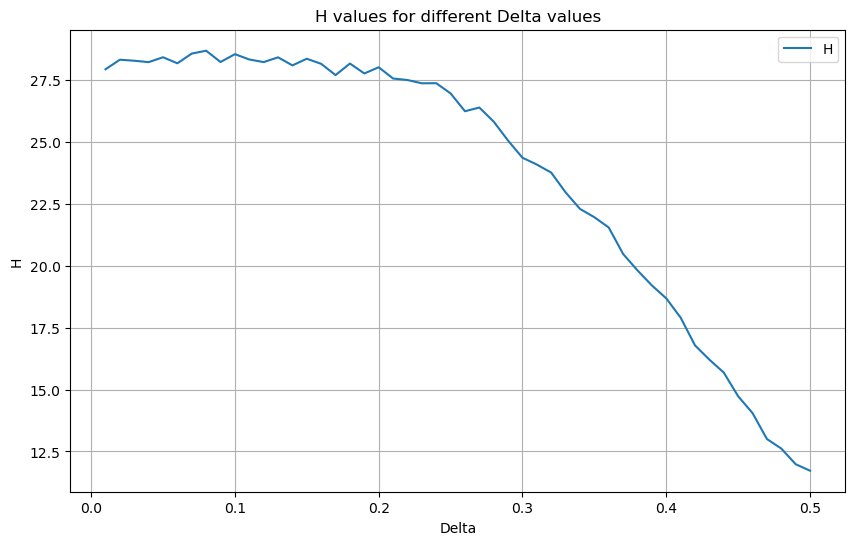

In [59]:
# Set the range of Delta values
Delta_values = np.linspace(0.01, 0.5, 50)
np.random.seed(123)
# Initialize a list to store the calculated H values
H_values = []

# Loop over the Delta values
for Delta in Delta_values:
    # Calculate H for the current Delta
    H = calculate_H(Delta)

    # Append the calculated H value to the list
    H_values.append(H)

# Find the Delta value that maximizes H
optimal_Delta = Delta_values[np.argmax(H_values)]

# Print the optimal Delta value
print(f"The optimal Delta value is {optimal_Delta}.")

# Plot H values against Delta values
plt.figure(figsize=(10,6))
plt.plot(Delta_values, H_values, label="H")
plt.xlabel("Delta")
plt.ylabel("H")
plt.title("H values for different Delta values")
plt.legend()
plt.grid(True)
plt.show()



**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [62]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [63]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

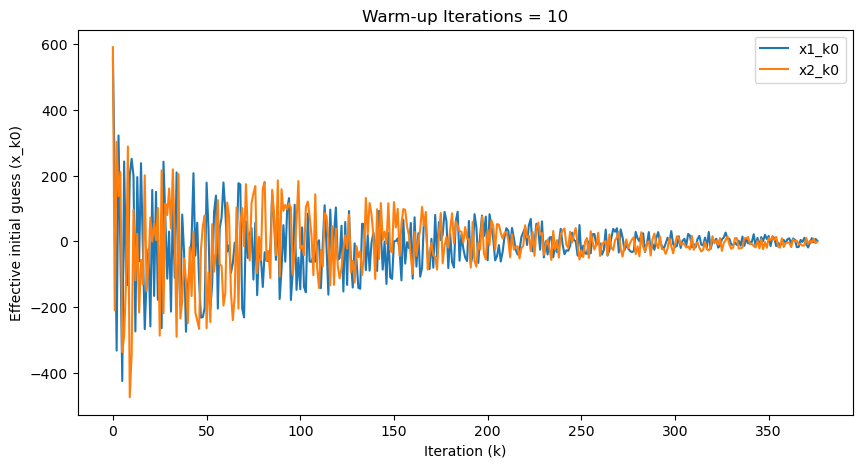

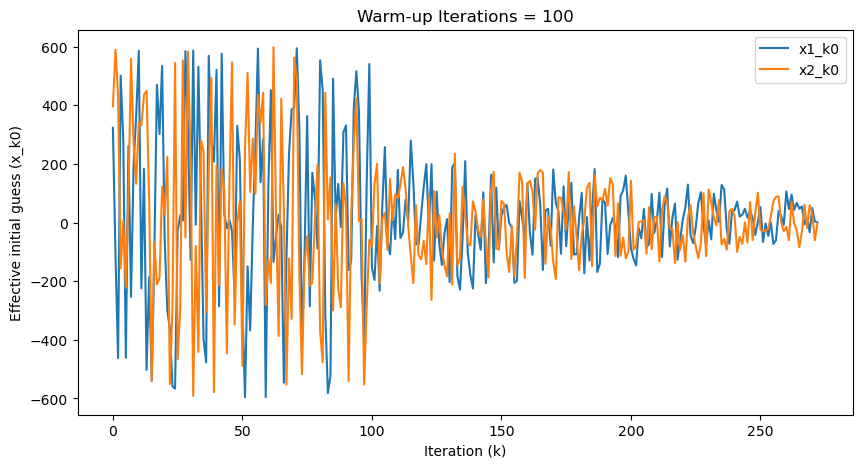

Convergence iterations for warm-up iterations 10 and 100:  [376, 272]
Accuracy measure for warm-up iterations 10 and 100:  [1.1102230246251565e-16, 1.1102230246251565e-16]
The final result is:  [-1.12326859e-08  8.02872441e-09]
The corresponding function value is:  1.1102230246251565e-16


In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

np.random.seed(123)

# Defining the Griewank function
def griewank(x):
    A = x[0]**2/4000 + x[1]**2/4000
    B = np.cos(x[0]/np.sqrt(1))*np.cos(x[1]/np.sqrt(2))
    return A-B+1

# 1. Choosing bounds and setting tolerance
bounds = np.array([[-600, 600], [-600, 600]])
tolerance = 1e-8

# 2. Choosing maximum number of iterations
max_iters = 1000

# Set initial guess
x_star = np.array([0, 0])

warm_up_iters_list = [10, 100]
convergence_iters = []
accuracy_measure = []

for warm_up_iters in warm_up_iters_list:
    x_star = np.array([0, 0])  # reset initial guess
    x_k0_values = []  # reset initial guesses list
    
    for k in range(max_iters):
        # 3.A: Draw random x^k uniformly within chosen bounds
        x_k = np.random.uniform(bounds[:, 0], bounds[:, 1])
        
        # 3.B, 3.C and 3.D
        if k >= warm_up_iters:
            chi_k = 0.50 * 2/(1 + np.exp((k-warm_up_iters)/100))
            x_k0 = chi_k * x_k + (1 - chi_k) * x_star
        else:
            x_k0 = x_k
        
        #3.E: Run optimizer with x_k0 as initial guess
        result = minimize(griewank, x_k0, method='BFGS', tol=tolerance)
        x_k_star = result.x

        #3.F
        if k == 0 or griewank(x_k_star) < griewank(x_star):
            x_star = x_k_star
        
        # Add x_k0 to list
        x_k0_values.append(x_k0)

        #3.G
        if griewank(x_star) < tolerance:
            break

    convergence_iters.append(k)
    accuracy_measure.append(np.abs(griewank(x_star)))

    # Plotting how the effective initial guesses x_k0 vary with the iteration counter k
    x_k0_values = np.array(x_k0_values)
    plt.figure(figsize=(10, 5))
    plt.plot(x_k0_values[:, 0], label='x1_k0')
    plt.plot(x_k0_values[:, 1], label='x2_k0')
    plt.xlabel('Iteration (k)')
    plt.ylabel('Effective initial guess (x_k0)')
    plt.title(f'Warm-up Iterations = {warm_up_iters}')
    plt.legend()
    plt.show()

print("Convergence iterations for warm-up iterations 10 and 100: ", convergence_iters)
print("Accuracy measure for warm-up iterations 10 and 100: ", accuracy_measure)

print("The final result is: ", x_star)
print("The corresponding function value is: ", griewank(x_star))

We see that initial iterations of 10 uses 355 iterations until the tolerance condition is met, while initial iterations of 100 uses 401 iterations before the condition is met. This however, could be a product of chance and for this reason we can simulate by Monte Carlo to find the mean number of iterations for each value of $\underline{K}$. By running the Monte Carlo simulation 50 times 

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [65]:
# Defining the Griewank function
def griewank(x):
    A = x[0]**2/4000 + x[1]**2/4000
    B = np.cos(x[0]/np.sqrt(1))*np.cos(x[1]/np.sqrt(2))
    return A-B+1

# 1. Choosing bounds and setting tolerance
bounds = np.array([[-600, 600], [-600, 600]])
tolerance = 1e-8

# 2. Choosing maximum number of iterations
max_iters = 1000

# Set initial guess
x_star = np.array([0, 0])

warm_up_iters_list = [10, 100]
num_sims = 50  # number of Monte Carlo simulations

all_convergence_iters = []
all_accuracy_measures = []

for sim in range(num_sims):
    np.random.seed(sim)  # set a different seed for each simulation
    convergence_iters = []
    accuracy_measure = []

    for warm_up_iters in warm_up_iters_list:
        x_star = np.array([0, 0])  # reset initial guess

        for k in range(max_iters):
            # 3.A: Draw random x^k uniformly within chosen bounds
            x_k = np.random.uniform(bounds[:, 0], bounds[:, 1])

            # 3.B, 3.C and 3.D
            if k >= warm_up_iters:
                chi_k = 0.50 * 2/(1 + np.exp((k-warm_up_iters)/100))
                x_k0 = chi_k * x_k + (1 - chi_k) * x_star
            else:
                x_k0 = x_k

            #3.E: Run optimizer with x_k0 as initial guess
            result = minimize(griewank, x_k0, method='BFGS', tol=tolerance)
            x_k_star = result.x

            #3.F
            if k == 0 or griewank(x_k_star) < griewank(x_star):
                x_star = x_k_star

            #3.G
            if griewank(x_star) < tolerance:
                break

        convergence_iters.append(k)
        accuracy_measure.append(np.abs(griewank(x_star)))

    all_convergence_iters.append(convergence_iters)
    all_accuracy_measures.append(accuracy_measure)

# Convert lists to arrays for easier calculations
all_convergence_iters = np.array(all_convergence_iters)
all_accuracy_measures = np.array(all_accuracy_measures)

# Calculate mean values
mean_convergence_iters = np.mean(all_convergence_iters, axis=0)
mean_accuracy_measure = np.mean(all_accuracy_measures, axis=0)

print("Mean convergence iterations for warm-up iterations 10 and 100: ", mean_convergence_iters)
print("Mean accuracy measure for warm-up iterations 10 and 100: ", mean_accuracy_measure)

With a mean convergence time of 309.4 for $\underline{K}=10$ versus 411.32 for $\underline{K}=100$ and with similar acuracies it is evident that it is not a better idea to use $\underline{K}=100$ over $\underline{K}=10$